This code is to be used if you want to fit FRET data that has two probe pairs like in;

Enoki, Thais A. et al.
Biophysical Journal, Volume 114, Issue 8, 1921 - 1935

Deeksha Mehta, Elizabeth K. Crumley, Jinchao Lou, Boris Dzikovski, Michael D. Best, M. Neal Waxham, and Frederick A. Heberle
The Journal of Physical Chemistry B 2025 129 (2), 671-683
DOI: 10.1021/acs.jpcb.4c06318

There are comments throughout as well as titles of each section. If you have any questions, please contact me at echaisso@vols.utk.edu


Load the packages required.
***You must do this first. ***

In [ ]:
import numpy
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
import csv
import os
import scipy
import scipy.stats
import math
import io
from ipywidgets import FloatSlider, Button, VBox, HBox, Output
import ipywidgets as widgets
from ipywidgets import Button, Output, VBox, HBox
from IPython.display import display
from google.colab import files
import pandas as pd
import io

You will load the files that you are wanting to analyze. It will first ask you for the total number of CSV files. The CSV file needs to be in the order of:
Temperature, FRET1, FRET2, Donor Probe1 Direct, Donor Probe2 Direct, Acceptor Probe3 Direct.
It has to be in CSV format, with headers!

In [1]:
# Initialize a list to store filenames (for reference)
filenames = []
nfile = int(input('Enter the number of files. '))
# Loop to upload files
for i in range(nfile):
    print(f"Upload file {i + 1}/{str(nfile)}")
    uploaded = files.upload()
    # Assuming only one file is uploaded at a time
    filename = list(uploaded.keys())[0]
    filenames.append(filename)
    # Load the CSV file into a DataFrame and assign to individual variable
    globals()[f"df{i+1}"] = pd.read_csv(io.BytesIO(uploaded[filename]))


# Access and print the first few rows of each DataFrame (you can use this as a check)
#for i in range(nfile):
    #df_name = f"df{i+1}"
    #print(f"First rows of {df_name}:")
    #print(globals()[df_name].head())


Enter the number of files. 


ValueError: invalid literal for int() with base 10: ''

This loads & stores the normalized FRET1 and FRET2 values. We normalize by general normalization.

In [ ]:
for i in range(nfile):
    df_name = f"df{i+1}"  # This is a string, not a reference to the DataFrame
    # Use globals() to reference the actual DataFrame by its variable name
    df = globals()[df_name]  # Access the actual DataFrame

    # Calculate FRET1 and FRET2 for this DataFrame
    FRET1_name = f"FRET1{i+1}"
    FRET2_name = f"FRET2{i+1}"

    # Now FRET1 and FRET2 calculations for general normalization
    FRET1 = df.iloc[:, 1] / (df.iloc[:, 3] * df.iloc[:, 5]) ** 0.5
    FRET2 = df.iloc[:, 2] / (df.iloc[:, 4] * df.iloc[:, 5]) ** 0.5

    # Store the results in the globals() dictionary as separate variables
    globals()[FRET1_name] = FRET1
    globals()[FRET2_name] = FRET2



You need to run this section if you want to plot each individual probe for each trial.

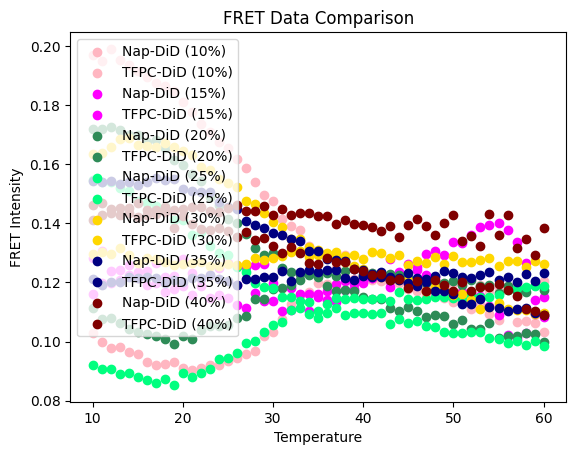

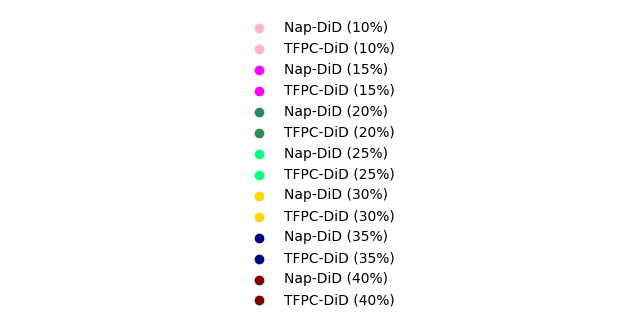

In [ ]:
##This plots them all on the same plot. You need to change the probe names and the colors for all of the values that are going to be done for the number
##of files on each value.


# List of probe labels and color mappings. The probe labels are going to be the labels for the legend.
##Probepair1 labels are the labels for the FRET1 pairs
probepair1_labels = ['Nap-DiD (10%)',  'Nap-DiD (15%)', 'Nap-DiD (20%)', 'Nap-DiD (25%)', 'Nap-DiD (30%)', 'Nap-DiD (35%)', 'Nap-DiD (40%)']
##Probepair2 labels are the labes for the FRET2 pairs
probepair2_labels = ['TFPC-DiD (10%)','TFPC-DiD (15%)','TFPC-DiD (20%)', 'TFPC-DiD (25%)','TFPC-DiD (30%)','TFPC-DiD (35%)','TFPC-DiD (40%)']
##The pp1color_labels goes with probepair1 labels. This list HAS to be the same size as probepair 1 labels
pp1color_labels = ['lightpink', 'magenta', 'seagreen', 'springgreen', 'gold', 'navy','maroon']
##The pp2color_labels goes with probepair2 labels. This list HAS to be the same size as probepair 2 labels
pp2color_labels = ['lightpink', 'magenta', 'seagreen', 'springgreen', 'gold', 'navy','maroon']

# Create the plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Loop through each dataset and plot corresponding FRET1 and FRET2
for i in range(nfile):
    # Construct dataset-specific variables dynamically
    df_name = f"df{i+1}"  # e.g., df1, df2, ...
    FRET1_name = f"FRET1{i+1}"  # e.g., FRET1_1, FRET1_2, ...
    FRET2_name = f"FRET2{i+1}"  # e.g., FRET2_1, FRET2_2, ...

    # Access the actual DataFrame and FRET1/FRET2 values using globals()
    df = globals()[df_name]
    FRET1 = globals()[FRET1_name]
    FRET2 = globals()[FRET2_name]

    # Plot the data for the current dataset
    ax.scatter(df.iloc[:,0], FRET1, label=probepair1_labels[i], color=pp1color_labels[i])  # FRET1 dataset
    ax.scatter(df.iloc[:,0], FRET2, label=probepair2_labels[i], color=pp2color_labels[i])  # FRET2 dataset

# Set plot labels and title
ax.set_xlabel('Temperature')
ax.set_ylabel('FRET Intensity')
ax.set_title('FRET Data Comparison')
ax.legend()  # Show legend, comment this out if you want to use the dummy legend (see below)

# Show the plot
plt.show()


# Create a dummy plot to generate the legend (use this if you have a large amount of data on the plot and the legend covers it.)
##This creates a dummy legend so you can copy & paste it in a final figure, but it does not show up on the plot.
handles, labels = ax.get_legend_handles_labels()
fig_legend = plt.figure(figsize=(8, 4))  # Adjust size as needed
plt.legend(handles, labels, loc='center', frameon=False)
plt.axis('off')  # Turn off axis for the legend-only figure
plt.show()

This seciton is going to be your model fitting section.

In [ ]:

def interactive_curve_fitting(nTemp, FRET1, FRET2):
   """
   Function to perform interactive curve fitting with buttons to adjust parameters.

   Parameters:
   - nTemp: array of temperature values
   - FRET1: array of FRET1 data
   - FRET2: array of FRET2 data
   """
   # Initial parameters (initial guesses)
   initial_guesses = (-0.00035, 0.02, -0.0008, 33, 0.87)
   updated_parameters = list(initial_guesses)  # Save initial parameters to updated_parameters

   # Define the increments for each parameter
   increments = [0.0001, 0.001, 0.001, 0.3, 0.01]

   output = Output()

   # Function to update plot based on parameter values
   def update_plot():
      nFRET = np.array(FRET2 / FRET1)  # Example formula for normalized FRET

      y_vals = m5(nTemp, *updated_parameters)

      with output:
        output.clear_output(wait=True)
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.scatter(nTemp, nFRET, label='Data')
        ax.plot(nTemp, y_vals, color='red', label='Fit')
        ax.legend()
        ax.set_xlabel('Temperature')
        ax.set_ylabel('Normalized FRET Intensity')
        ax.set_title('Interactive Curve Fitting')
        plt.show()

   # Function to update parameter values
   def update_parameter(index, increment):
      nonlocal updated_parameters
      updated_parameters[index] += increment
      update_plot()

   # Function to create buttons for each parameter with labels
   def create_parameter_buttons(index):
      button_minus = Button(description=f'◄ {increments[index]:.4f}', layout={'width': '100px'})
      button_plus = Button(description=f'► {increments[index]:.4f}', layout={'width': '100px'})

      button_minus.on_click(lambda _: update_parameter(index, -increments[index]))
      button_plus.on_click(lambda _: update_parameter(index, increments[index]))

      return HBox([button_minus, button_plus])

   # Function for the Done button to save the updated parameters
   def on_done_click(_):
      global parameters  # Make the parameters global so we can access it outside
      parameters = updated_parameters.copy()
      print("Updated parameters:", parameters)  # Optionally print or display the parameters

   # Create buttons for each parameter
   parameter_buttons = [create_parameter_buttons(i) for i in range(len(initial_guesses))]

   # Create Done button
   done_button = Button(description="Done", layout={'width': '100px', 'height': '40px', 'background': '#4CAF50', 'color': 'white'})
   done_button.on_click(on_done_click)  # Assign the callback to the Done button

   # Display widgets and initial plot
   display(VBox([HBox(parameter_buttons), done_button, output]))

   # Initial plot update
   update_plot()



In [ ]:
import numpy as np
from scipy.optimize import curve_fit
# Define your model function
def p5(x, a, b, z, xi, y):
   result = np.where(x < xi, (x - xi) * (b + a * (x + xi)) + y, z * x - z * xi + y)
   return result

# Define the model function for curve fitting
def m5(x, a, b, z, xi, y):
   return p5(x, a, b, z, xi, y)
import numpy as np
from scipy.optimize import curve_fit

def calculate_curve_fit(nTemp, nFRET, updated_parameters):
   """
   Function to perform curve fit and calculate residuals, chi-square statistic, and Tm.

   Parameters:
   - nTemp: array of temperature values
   - nFRET: array of normalized FRET data
   - updated_parameters: list of initial parameters for curve fit

   Returns:
   - popt: optimized parameters from curve fit
   - pcov: covariance matrix from curve fit
   - residuals: residuals from curve fit
   - chi_square: chi-square statistic
   - reduced_chi_square: reduced chi-square statistic
   - y: fitted curve values
   - Tm: transition temperature (xi)
   """
   # Perform the curve fit
   popt, pcov = curve_fit(p5, nTemp, nFRET, p0=updated_parameters)
   y = p5(nTemp, *popt)  # Compute fitted curve

   # Calculate the residuals and chi-square statistic
   residuals = nFRET - y
   chi_square = np.sum((residuals**2) / np.var(nFRET))
   degrees_of_freedom = len(nTemp) - len(popt)
   reduced_chi_square = chi_square / degrees_of_freedom

   # Extract the transition temperature (xi)
   Tm = popt[3]  # Assuming xi is the fourth parameter


   return popt, pcov, residuals, chi_square, reduced_chi_square, y, Tm



This applies the function above to each of the CSVs. You can only hit done once. This allows for an interacting fit of the models. This allows for better fitting. (it is not a necessity, however even if you do not adjust the parameters you MUST hit done before running the next section of code. If you do not, the code will break.)

In [ ]:
# Loop through each dataset and plot corresponding FRET1 and FRET2
fitParams = [];
for i in range(nfile):
    # Construct dataset-specific variables dynamically
    df_name = f"df{i+1}"  # e.g., df1, df2, ...
    FRET1_name = f"FRET1{i+1}"  # e.g., FRET1_1, FRET1_2, ...
    FRET2_name = f"FRET2{i+1}"  # e.g., FRET2_1, FRET2_2, ...

    # Access the actual DataFrame and FRET1/FRET2 values using globals()
    df = globals()[df_name]
    FRET1 = globals()[FRET1_name]
    FRET2 = globals()[FRET2_name]
    interactive_curve_fitting(df.iloc[:,0], FRET1, FRET2)
    fitParams.append(parameters)



The section below uses model fit to fit each of the loaded data sets to find the transition temperature.  

In [ ]:
FitY = [];
ListChi = [];
ListRChi = [];
ListTm = [];
for i in range(nfile):  # Assuming you have 10 datasets
    # Construct dataset-specific variables dynamically
    df_name = f"df{i+1}"  # e.g., df1, df2, ...
    FRET1_name = f"FRET1{i+1}"  # e.g., FRET1_1, FRET1_2, ...
    FRET2_name = f"FRET2{i+1}"  # e.g., FRET2_1, FRET2_2, ...

    # Access the actual DataFrame and FRET1/FRET2 values using globals()
    df = globals()[df_name]
    FRET1 = globals()[FRET1_name]
    FRET2 = globals()[FRET2_name]
    popt, pcov, residuals, chi_square, reduced_chi_square, y, Tm = calculate_curve_fit(df.iloc[:,0], FRET2/FRET1, parameters)
    FitY.append(y)
    ListChi.append(chi_square)
    ListRChi.append(reduced_chi_square)
    ListTm.append(Tm)


This is the part of the code that will plot all of the FRET1/FRET2 curves for each of the datasets.

Enter the names of you Data Sets Seperated by commas: 1,1,1,1,1,1,1
[33.53400550772361, 27.61332259641769, 30.41840859236844, 30.447451461426912, 32.43794005937259, 33.968136198177405, 30.999991171221605]


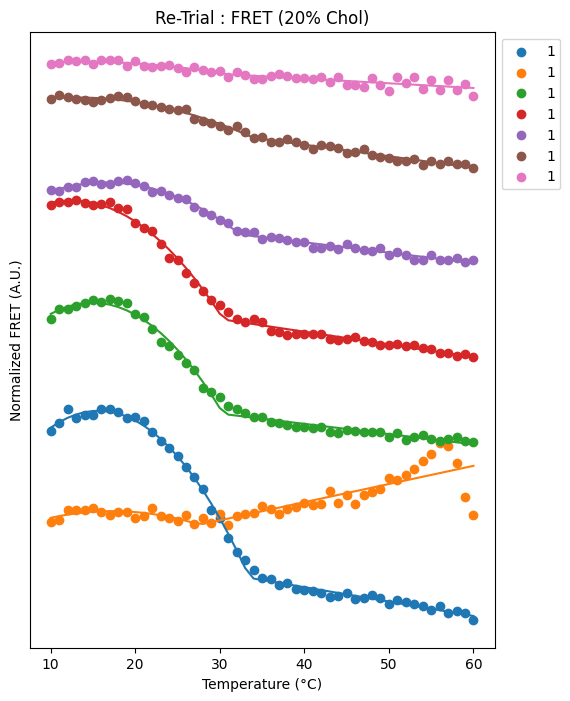

In [ ]:
DataNames = input('Enter the names of you Data Sets Seperated by commas: ')
dataNames = DataNames.split(',')

plt.figure(figsize=(6, 8))
for i in range(nfile):  # Assuming you have 10 datasets
    # Construct dataset-specific variables dynamically
    df_name = f"df{i+1}"  # e.g., df1, df2, ...
    FRET1_name = f"FRET1{i+1}"  # e.g., FRET1_1, FRET1_2, ...
    FRET2_name = f"FRET2{i+1}"  # e.g., FRET2_1, FRET2_2, ...

    # Access the actual DataFrame and FRET1/FRET2 values using globals()
    df = globals()[df_name]
    FRET1 = globals()[FRET1_name]
    FRET2 = globals()[FRET2_name]
    plt.scatter(df.iloc[:,0], FRET2/FRET1+i/2, label=dataNames[i])
    plt.plot(df.iloc[:,0], FitY[i]+i/2)
    plt.ylabel("Normalized FRET (A.U.)")
    #plt.annotate(str(round(ListTm[i], 2)), (df['Temp'][35], FitY[i][35]+i/1.9), weight="bold")
    plt.xlabel("Temperature (°C)")
    plt.yticks([])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.title("Re-Trial : FRET (20% Chol)")

print(ListTm)


This will plot a bar plot with the sample number on the x-axis and the tm on as the bar height.

In [ ]:
plt.figure(figsize=(6, 4))
plt.ylim(0, np.max(ListTm) + 3)
for i in range(nfile):
  plt.bar(i, ListTm[i])
  plt.annotate(str(round(ListTm[i], 2)), (i-0.5, ListTm[i]+0.5), weight="bold")
  ##Change the name below for the
  plt.xlabel('Sample Number')
  plt.ylabel("Tm (in °C)")
  xticks_positions = np.linspace(0, 9, 10)
  plt.xticks(xticks_positions)

ValueError: zero-size array to reduction operation maximum which has no identity

<Figure size 600x400 with 0 Axes>

This will plot only the FRET1 Data

Enter the names of you Data Sets Seperated by commas: 1,2,3


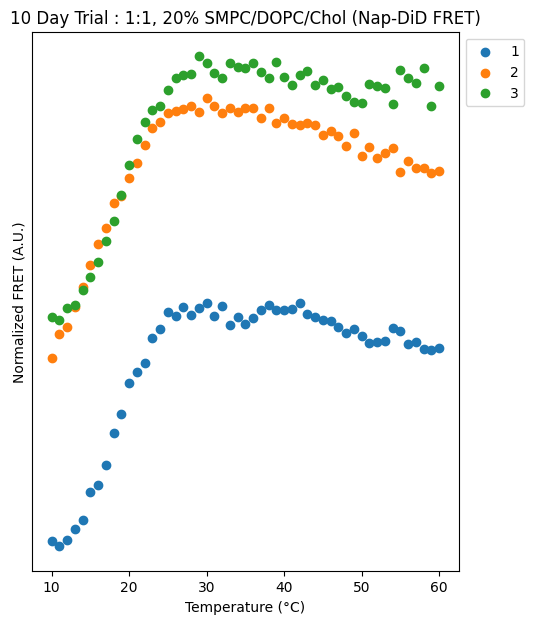

In [ ]:
DataNames = input('Enter the names of you Data Sets Seperated by commas: ')
dataNames = DataNames.split(',')

plt.figure(figsize=(5.5, 7))
for i in range(nfile):  # Assuming you have 10 datasets
    # Construct dataset-specific variables dynamically
    df_name = f"df{i+1}"  # e.g., df1, df2, ...
    FRET1_name = f"FRET1{i+1}"  # e.g., FRET1_1, FRET1_2, ...
    FRET2_name = f"FRET2{i+1}"  # e.g., FRET2_1, FRET2_2, ...

    # Access the actual DataFrame and FRET1/FRET2 values using globals()
    df = globals()[df_name]
    FRET1 = globals()[FRET1_name]
    FRET2 = globals()[FRET2_name]
    plt.scatter(df['Temp'], FRET1+i/31, label=dataNames[i])
    plt.ylabel("Normalized FRET (A.U.)")
    plt.xlabel("Temperature (°C)")
    plt.yticks([])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #Change this if you would like to change the title
    plt.title("10 Day Trial : 1:1, 20% SMPC/DOPC/Chol (Nap-DiD FRET)")


This plots only the FRET2 data

Enter the names of you Data Sets Seperated by commas: 1,2,3


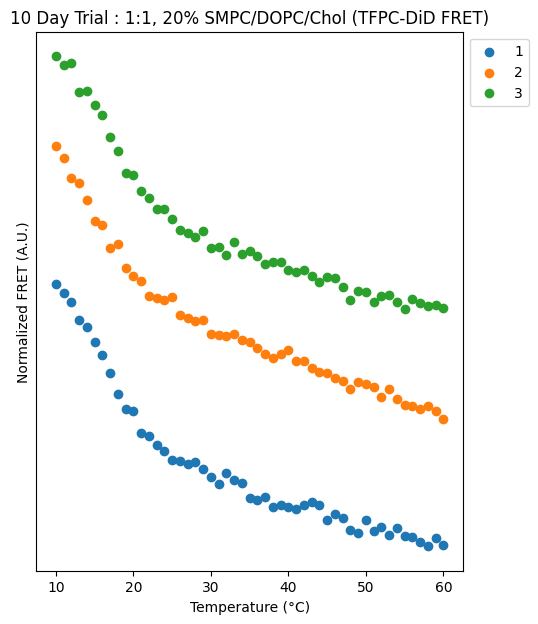

In [ ]:
DataNames = input('Enter the names of you Data Sets Seperated by commas: ')
dataNames = DataNames.split(',')

plt.figure(figsize=(5.5, 7))
for i in range(nfile):  # Assuming you have 10 datasets
    # Construct dataset-specific variables dynamically
    df_name = f"df{i+1}"  # e.g., df1, df2, ...
    FRET1_name = f"FRET1{i+1}"  # e.g., FRET1_1, FRET1_2, ...
    FRET2_name = f"FRET2{i+1}"  # e.g., FRET2_1, FRET2_2, ...

    # Access the actual DataFrame and FRET1/FRET2 values using globals()
    df = globals()[df_name]
    FRET1 = globals()[FRET1_name]
    FRET2 = globals()[FRET2_name]
    plt.scatter(df['Temp'], FRET2+i/28, label=dataNames[i])
    plt.ylabel("Normalized FRET (A.U.)")
    plt.xlabel("Temperature (°C)")
    plt.yticks([])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    #Change this if you want to change the title
    plt.title("10 Day Trial : 1:1, 20% SMPC/DOPC/Chol (TFPC-DiD FRET)")